In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
#sys.path.append('/content/gdrive/My Drive/dcgan-mnist-tensorflow-master')
sys.path.append('/content/gdrive/MyDrive/src_symptom')
sys.path.append('/content/gdrive/MyDrive/Model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import floor


def zero():
    return np.random.uniform(0.0, 0.01, size = [1])

def one():
    return np.random.uniform(0.99, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])

print("Importing Images...")

Images = []
#images_path = os.getcwd() + '\images'
images_path = '/content/gdrive/MyDrive/src_symptom/src_disease/rust/'
files = os.listdir(images_path)

for n in range(1, len(files)):
    temp1 = Image.open(f"/content/gdrive/MyDrive/src_symptom/src_disease/rust/{str(n).zfill(5)}.jpg")
                
    temp = np.array(temp1.convert('RGB'), dtype='float32')
    
    Images.append(temp / 255)
    
    Images.append(np.flip(Images[-1], 1))
    
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D, GaussianNoise
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam
    
class GAN(object):
    
    def __init__(self):
        
        #Models
        self.D = None
        self.G = None
        
        self.OD = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = 0.0001
        self.steps = 1
        
        #LossPlot
        self.adversarial_loss = np.empty(shape=1)
        self.discriminator_loss = np.empty(shape=1)
        self.batches = np.empty(shape=1)

    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        
        #add Gaussian noise to prevent Discriminator overfitting
        self.D.add(GaussianNoise(0.2, input_shape = [256, 256, 3]))
        
        #256x256x3 Image
        self.D.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #128x128x8
        self.D.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #64x64x16
        self.D.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #32x32x32
        self.D.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #16x16x64
        self.D.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #8x8x128
        self.D.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #4x4x256
        self.D.add(Flatten())
        
        #256
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))
        
        self.D.add(Dense(1, activation = 'sigmoid'))
        
        return self.D
    
    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
        
        #1x1x4096 
        self.G.add(Conv2DTranspose(filters = 256, kernel_size = 4))
        self.G.add(Activation('relu'))
        
        #4x4x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #8x8x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #16x16x128
        self.G.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #32x32x64
        self.G.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #64x64x32
        self.G.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #128x128x16
        self.G.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #256x256x8
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))
        
        return self.G
    
    def DisModel(self):
        
        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())
        
        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.DM
    
    def AdModel(self):
        
        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())
            
        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.AM
    
    def sod(self):
        
        self.OD = self.D.get_weights()
        
    def lod(self):
        
        self.D.set_weights(self.OD)



class Model_GAN(object):
    
    def __init__(self):
        
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
    def train(self, batch = 16):
        
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)
        
        #LinePlot
        self.GAN.adversarial_loss = np.append(self.GAN.adversarial_loss, c)
        self.GAN.discriminator_loss = np.append(self.GAN.discriminator_loss, a+b)
        self.GAN.batches = np.append(self.GAN.batches, model.GAN.steps)

        print(f"D Real: {str(a)}, D Fake: {str(b)}, G All: {str(c)}")
        
        if self.GAN.steps % 500 == 0:
            self.save(floor(self.GAN.steps / 1000))
            self.evaluate()
            
        if self.GAN.steps % 5000 == 0:
            self.GAN.AM = None
            self.GAN.DM = None
            self.AdModel = self.GAN.AdModel()
            self.DisModel = self.GAN.DisModel()
        
        self.GAN.steps = self.GAN.steps + 1
        
    def train_dis(self, batch):
        
        #Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(one())
            label_data.append(zero())
            
        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))
        
        #Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2)))
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(zero())
            label_data.append(one())
            
        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))
        
        return (d_loss_real, d_loss_fake)
        
    def train_gen(self, batch):
        
        self.GAN.sod()
        
        label_data = []
        for i in range(int(batch)):
            #label_data.append(one())
            label_data.append(zero())
        
        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))
        
        self.GAN.lod()
        
        return g_loss
        
    def evaluate(self):
        
        im_no = random.randint(0, len(Images) - 1)
        im1 = Images[im_no]
        
        im2 = self.generator.predict(noise(2))
        
        plt.figure(1)
        plt.imshow(im1)
        
        plt.figure(2)
        plt.imshow(im2[0])
        
        plt.figure(3)
        plt.imshow(im2[1])
        
        plt.show()
        
    def save(self, num):
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("/content/gdrive/MyDrive/Model/rust/gen/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("/content/gdrive/MyDrive/Model/rust/disc/dis.json", "w+") as json_file:
            json_file.write(dis_json)

        self.GAN.G.save_weights("/content/gdrive/MyDrive/Model/rust/gen/gen"+str(num)+".h5")
        self.GAN.D.save_weights("/content/gdrive/MyDrive/Model/rust/disc/dis"+str(num)+".h5")

        print(f"Model number {str(num)} Saved!")

    def load(self, num):
        steps1 = self.GAN.steps
        
        self.GAN = None
        self.GAN = GAN()

        #Generator
        gen_file = open("/content/gdrive/MyDrive/Model/cercospora/gen/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()
        
        self.GAN.G = model_from_json(gen_json)
        self.GAN.G.load_weights("/content/gdrive/MyDrive/Model/cercospora/gen/gen"+str(num)+".h5")

        #Discriminator
        dis_file = open("/content/gdrive/MyDrive/Model/cercospora/disc/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()
        
        self.GAN.D = model_from_json(dis_json)
        self.GAN.D.load_weights("/content/gdrive/MyDrive/Model/cercospora/disc/dis"+str(num)+".h5")

        #Reinitialize
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        
        self.GAN.steps = steps1
        
    def eval2(self, num):
        
        im2 = self.generator.predict(noise(1))
        
        r1 = np.concatenate(im2[:1], axis = 1)
        #r1 = np.concatenate(im2[:8], axis = 1)
        #r2 = np.concatenate(im2[8:16], axis = 1)
        #r3 = np.concatenate(im2[16:24], axis = 1)
        #r4 = np.concatenate(im2[24:32], axis = 1)
        #r5 = np.concatenate(im2[32:40], axis = 1)
        #r6 = np.concatenate(im2[40:48], axis = 1)
        
        #c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)
        c1 = np.concatenate([r1], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("/content/gdrive/MyDrive/FakeSymptom/train/extras/cercospora/"+str(num)+".jpg")
        
       

Importing Images...


In [ ]:
model = Model_GAN()
model.GAN.D.summary()
model.GAN.G.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 8)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)     

In [ ]:
os.mkdir('Results')
os.mkdir('Models')

In [ ]:
#if training new model:
model = Model_GAN() 
model.GAN.D.summary()
model.GAN.G.summary()

print("We're off! See you in a while!")
#model.GAN.steps = 165001
while(model.GAN.steps < 100000):
    
    #print("\n\n\n\nRound " + str(model.GAN.steps) + ":")
    model.train()
    if model.GAN.steps % 500 == 0:
        print("\nRound: " + str(model.GAN.steps))
    
    if model.GAN.steps % 1000 == 0:
        print("\n\n\n\nRound " + str(model.GAN.steps) + ":")
        model.eval2(int(model.GAN.steps / 1000))
        
        #model.GAN.batches = np.append(model.GAN.batches, model.GAN.steps)

        # Each epoch update the loss graphs
        #if model.GAN.steps % 
        plt.figure(1, figsize=(15,3))
        plt.plot(model.GAN.batches, model.GAN.adversarial_loss, color='green',
                 label='Generator Loss')
        plt.plot(model.GAN.batches, model.GAN.discriminator_loss, color='blue',
                 label='Discriminator Loss')
        plt.title("DCGAN Train")
        plt.xlabel("Batch Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.pause(0.0000000001)
        plt.show()
        plt.savefig('/content/gdrive/MyDrive/augmented_folder/trainingLossPlot.jpg')

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from matplotlib import pyplot

def save_plot(examples, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = "fake.png"
    pyplot.savefig(filename)
    pyplot.close()

if __name__ == "__main__":
    
    model = Model_GAN()
    model.GAN.D.summary()
    model.GAN.G.summary() 

    val = 32
    model.load(val)

    i = 0
    for i in range(218):
      model.eval2(i)
    #model.load_weights("/content/gdrive/MyDrive/Models/generator/gen57.h5")

    #model.suummary()

    #n_samples = 25     ## n should always be a square of an integer.
    #latent_dim = 128
    #latent_points = np.random.normal(size=(n_samples, latent_dim))
    #examples = model.predict(latent_points)
    #save_plot(examples, int(np.sqrt(n_samples)))

In [ ]:
import os
# Function to rename multiple files
def main():
   i = 576
   
   path="/content/gdrive/MyDrive/FakeSymptom/train/extras/cercospora/"
   for filename in os.listdir(path):
      my_dest = str(i) + ".jpg"
      my_source =path + filename
      my_dest =path + my_dest
      # rename() function will
      # rename all the files
      os.rename(my_source, my_dest)
      i += 1
# Driver Code
if __name__ == '__main__':
   # Calling main() function
   main()

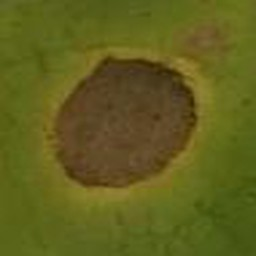

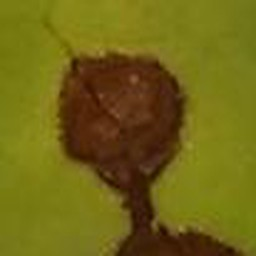

In [ ]:
  import cv2
  from google.colab.patches import cv2_imshow
  
  img2 = cv2.imread('/content/drive/MyDrive/src_symptom/src_disease/cercospora/00004.jpg')
  img = cv2.imread('/content/drive/MyDrive/augment_images/disease/cercospora/5.jpg')

  cv2_imshow(img2)
  cv2_imshow(img)
  

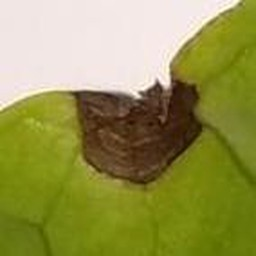

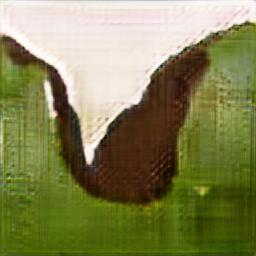

In [ ]:
img3 = cv2.imread('/content/drive/MyDrive/src_symptom/src_disease/phoma/00113.jpg')
img1 = cv2.imread('/content/drive/MyDrive/augment_images/disease/phoma/440.jpg')

cv2_imshow(img3)
cv2_imshow(img1)